In [1]:
#loading libraries

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,max_error,mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset
import arch

In [2]:
#setting time range

start = '2010-06-09'
end = '2023-03-03'

In [3]:
#downloading data

oil = yf.download('CL=F', start = start,
                   end = end, interval='1wk')['Adj Close'].rename('Oil', inplace=True).reset_index().drop(['Date'],axis=1)

natgas = yf.download('NG=F', start = start,
                   end = end, interval='1wk')['Adj Close'].rename('Natgas', inplace=True).reset_index().drop(['Date'],axis=1)

gold = yf.download('GOLD', start = start,
                   end = end, interval='1wk')['Adj Close'].rename('Gold', inplace=True).reset_index().drop(['Date'],axis=1)

sp500 = yf.download('^GSPC', start = start,
                   end = end, interval='1wk')['Adj Close'].rename('SP500', inplace=True).reset_index().drop(['Date'],axis=1)

corn = yf.download('CORN', start = start,
                   end = end, interval='1wk')['Adj Close'].rename('Corn', inplace=True).reset_index().drop(['Date'],axis=1)

steelStock = yf.download('X', start = start,
                   end = end, interval='1wk')['Adj Close'].rename('Steelstock', inplace=True).reset_index().drop(['Date'],axis=1)

EURUSD = yf.download('EURUSD=X', start = start,
                   end = end, interval='1wk')['Adj Close'].rename('EURUSD', inplace=True).reset_index().drop(['Date'],axis=1)

merged = pd.concat([oil,natgas,gold,sp500,corn,steelStock,EURUSD],
                   axis=1, join="inner")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


I decided to use given delays, because its p-values were the lowest:

In [4]:
#setting variables

oil_delayed = np.log(merged['Oil'].shift(11)).drop(range(23))

natgas_delayed = np.log(merged['Natgas'].shift(1)).drop(range(23))

gold_delayed = np.log(merged['Gold'].shift(2)).drop(range(23))

steel_delayed = np.log(merged['Steelstock'].shift(1)).drop(range(23))

EURUSD_delayed = np.log(merged['EURUSD'].shift(23)).drop(range(23))

corn_delayed = np.log(merged['Corn'].shift(16)).drop(range(23))

y = np.log(merged['SP500'])

X = pd.concat([oil_delayed,natgas_delayed,gold_delayed,steel_delayed,EURUSD_delayed,corn_delayed],
              axis=1,join='inner').reset_index(drop=True)

y.drop(range(23),inplace=True)
y.reset_index(drop=True, inplace=True)


In [5]:
#splitting into train and test set

periods_to_forecast = 10

y_train = y[:len(y)-periods_to_forecast]

y_test = y[len(y)-periods_to_forecast:]

X_train = X[:len(X)-periods_to_forecast]

X_test = X[len(X)-periods_to_forecast:]

The null hypothesis: there is a unit root in an AR model <br>
First test below implies that the data series is not stationary, so the test should be done one more time in differenced data.<br>
Second test implies that differenced data series is stationary, so 'I' parameter for ARIMA model should equal 1.

In [6]:
#Checking if differencing is needed in ARIMA model

print('Augmented Dickey-Fuller test p-value for not differenced data: ',
      adfuller(y_train)[1])
print('\nAugmented Dickey-Fuller test p-value for first order differentiation: ',
      adfuller(y_train.diff().dropna())[1])

Augmented Dickey-Fuller test p-value for not differenced data:  0.6912296216402447

Augmented Dickey-Fuller test p-value for first order differentiation:  0.0


To prevent autocorrelation in my ARIMA model I draw ACF plot. From the plot below I choose particural AR parameters: 1,4,5,10 (I consider only AR<=10).

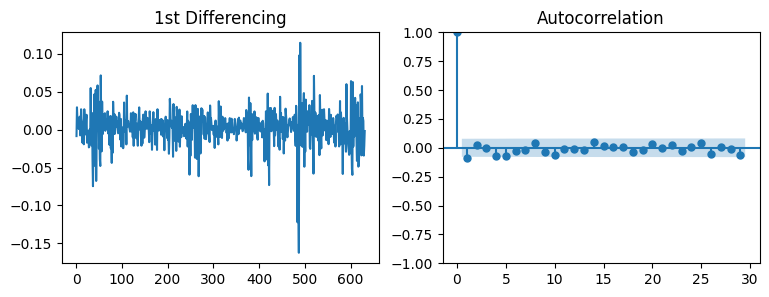

In [7]:
#Autocorrelation plot of differenced series

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_train.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(y_train.diff().dropna(), ax=axes[1])
plt.show()

Then I plot Partial Autocorrelation to check if any MA parameter should be added to my ARIMA model. <br>
The best solution is not to add any MA parameter, but it's also worth check MA=1 (it produces worse results than MA=0).

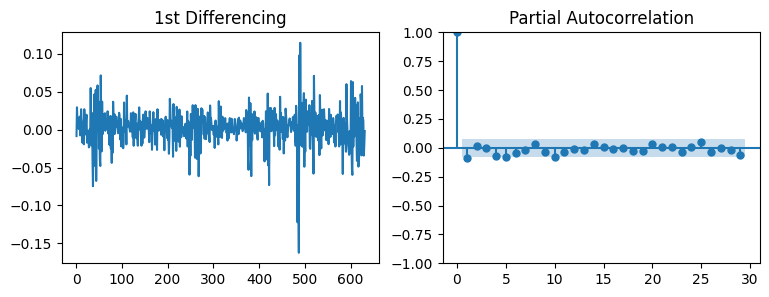

In [8]:
#Partial autocorrelation plot

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_train.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(y_train.diff().dropna(), ax=axes[1], method='ywm')
plt.show()

In [9]:
#setting parameters for ARIMA model

p,d,q = [1,4,5,10], 1, 0

#buiilding ARIMA model

sarimax_model = SARIMAX(endog=y_train, exog=X_train, order=(p,d,q))

model = sarimax_model.fit(maxiter=200)

print(model.summary())

                                    SARIMAX Results                                     
Dep. Variable:                            SP500   No. Observations:                  632
Model:             SARIMAX([1, 4, 5, 10], 1, 0)   Log Likelihood                1499.376
Date:                          Sat, 04 Mar 2023   AIC                          -2976.752
Time:                                  14:44:56   BIC                          -2927.831
Sample:                                       0   HQIC                         -2957.751
                                          - 632                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Oil           -0.0369      0.016     -2.369      0.018      -0.067      -0.006
Natgas        -0.0311      0.012     -2.635      0.

The summary above implies that rising prices of energy and transport (oil and gas) and rising prices of gold and corn should cause that the price of S&P500 index will be lower(for example 1% oil price growth (delayed by 11 weeks) leads to lower index price by 0.0382%).<br>
From the other hand, rising value of dollar and steel leads to S&P500 index price growth. <br>
Presented coefficients seem to be logical, because their signs are the same as I expected before building ARIMA model.

In [10]:
#Statistical tests for this model

print('Autocorrelation p-values for delays from 1 to 14:\n',
      model.test_serial_correlation(method='ljungbox',lags=range(14))[0][1][:],'\n')

print('Normality test p-value: ',
      model.test_normality(method='jarquebera')[0][1],'\n')

print('Heteroskedasticity test p-value: ',
      model.test_heteroskedasticity(method='breakvar')[0][1],'\n')



Autocorrelation p-values for delays from 1 to 14:
 [       nan 0.72392734 0.8344136  0.93660714 0.97201721 0.97211127
 0.60005613 0.67994624 0.76403496 0.66948458 0.75420233 0.80907522
 0.8606685  0.90427028] 

Normality test p-value:  8.042154954987983e-299 

Heteroskedasticity test p-value:  1.0921205674729936e-09 



From above statistics tests it should be noticed that there is no problem of autocorrelation, but main problem of presented model is heteroskedasticity. If it comes to normality test, the model's distribution is not normal distribution, but it's not a problem as it has over 600 observations. <br><br>
Only problem, that should be solved is heteroskedasticity problem, because it can make model's predictions less accurate.<br>
However I decided to check the model's quality predictions.


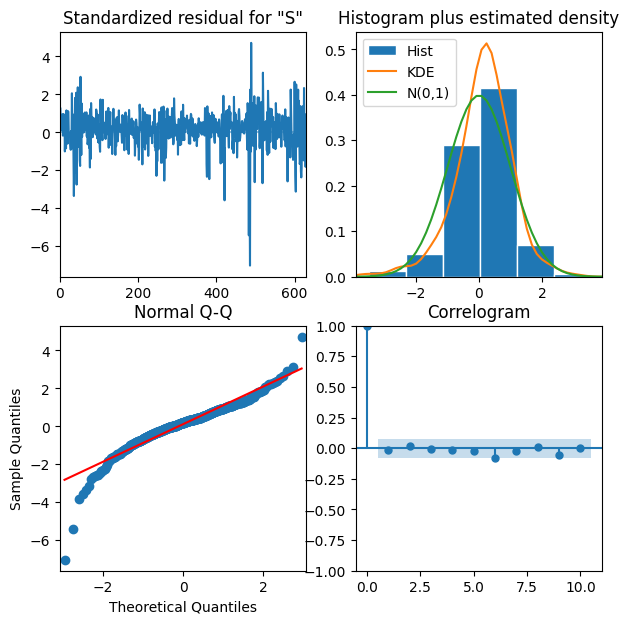

In [11]:
#Visualization

model.plot_diagnostics(figsize=(7,7))
plt.show()

Upper left diagram indices that there is undoubtly heteroskedasticity problem.<br><br>
Upper right diagram shows that there is a difference between model's distribution and normal distribution. <br><br>
Lower left: As all blue dots are not close to red line, the distribution is skewed (but it also can be seen in upper right plot).<br><br>
Lower right plot implies there is no autocorrelation problem.

In [12]:
#Predicting

forecast = pd.DataFrame(model.forecast(steps=periods_to_forecast, exog=X_test))

prediction = pd.DataFrame(model.predict(n_periods=len(X_train), X=X_train)).drop(0)

forecast_prediction = pd.concat([prediction,forecast],
              axis=0,join='inner')

#Confidence interval (significance level is set to 0.1)

conf_int = model.get_forecast(steps=periods_to_forecast, exog=X_test, alpha=0.1).conf_int()


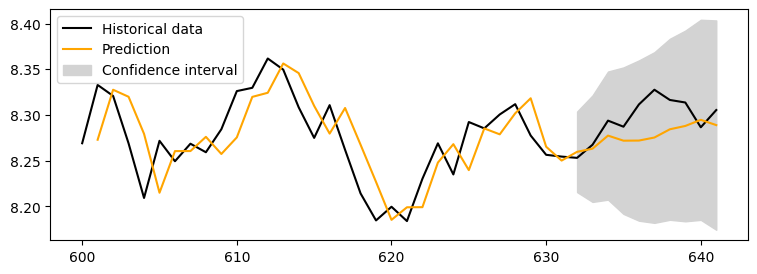

In [13]:
#Plotting predictions

plt.plot(y[600:], label='Historical data', color='black')
plt.plot(forecast_prediction[600:], label='Prediction', color='orange')
plt.fill_between(conf_int.index,conf_int['lower SP500'],conf_int['upper SP500'],
                 color='lightgray', label='Confidence interval')
plt.legend(loc='upper left')
plt.show()

The plot above presents predictions, historical data and confidence interval. <br>
Model's predictions seem to be delayed, but it reflects the trend.

In [14]:
#Evaluating prediction's quality

print('Max error: ', max_error(y_test, forecast))
print('MAE: ',mean_absolute_error(y_test, forecast))
print('MAPE: ',mean_absolute_percentage_error(y_test, forecast))
print('MSE: ',mean_squared_error(y_test, forecast))


Max error:  0.052257490217863634
MAE:  0.021666763608976503
MAPE:  0.002607556180980052
MSE:  0.0006878903128423916


Particular errors from this model seems to be quite low (note that for all the values natural logarithm have been used). <br><br>
The main problem is heteroskedasticity so I decided to use GARCH model to do volatility modelling.

In [15]:
arima_residuals = model.resid.drop(0)
arima_residuals_multby1000 = arima_residuals.apply(lambda x: x*1000) 
garch = arch.arch_model(arima_residuals_multby1000, p=3, q=0, o=0)
garch_fitted = garch.fit(update_freq=10)
garch_fitted.summary()

Iteration:     10,   Func. Count:     68,   Neg. LLF: 2775.4017720490247
Iteration:     20,   Func. Count:    128,   Neg. LLF: 2767.9516035256474
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2767.9515714456184
            Iterations: 23
            Function evaluations: 147
            Gradient evaluations: 23


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2767.95
Distribution:                  Normal   AIC:                           5545.90
Method:            Maximum Likelihood   BIC:                           5568.14
                                        No. Observations:                  631
Date:                Sat, Mar 04 2023   Df Residuals:                      630
Time:                        14:48:20   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             4.2136      0.673      6.262  3.794e-10 [  2.895,  5.532]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega        144.9288     26.095      5.554  2.794e-08 [ 93.783,1.961e+02]
alpha[1]       0.2567  7.666e-02      3.348  8.132e-04   [  0.106,  0.407]
alpha[2]       0.2272  8.994e-02      2.526  1.152e-02 [5.095e-02,  0.403]
alpha[3]       0.3221      0.130      2.479  1.319e-02 [6.738e-02,  0.577]
==========================================================================

Covariance estimator: robust
"""

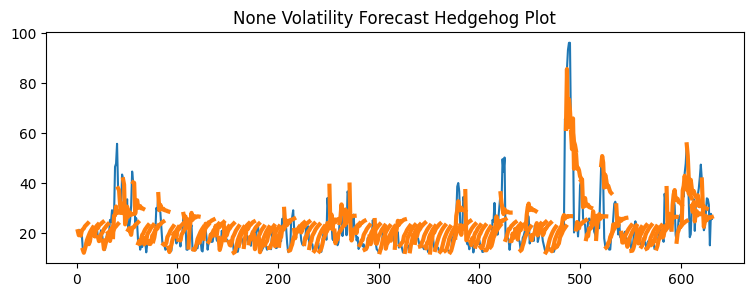

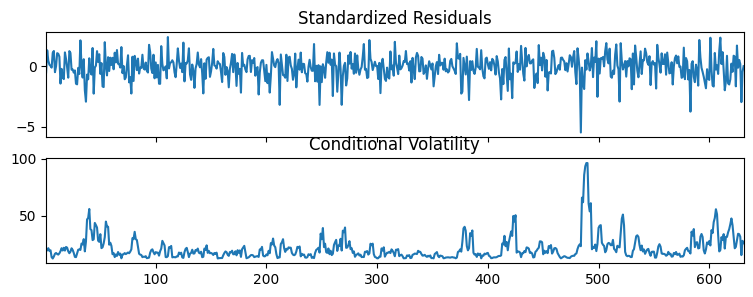

In [16]:
garch_fitted.hedgehog_plot(step=5)
plt.show()
garch_fitted.plot()
plt.show()

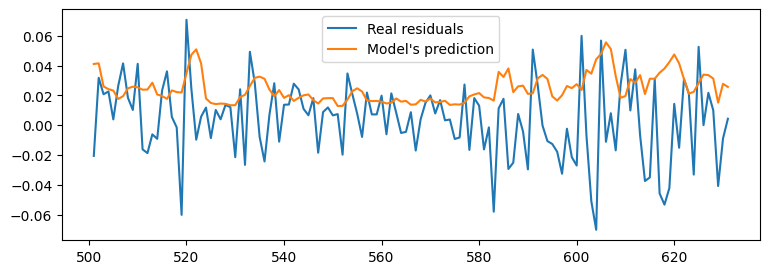

In [17]:
garch_forecast = garch_fitted.forecast(horizon=periods_to_forecast, reindex=True)
cor_indx = list(range(len(y)-periods_to_forecast,len(y)))
forecasted_mean = garch_forecast.mean.iloc[-1].rename('predicted_mean', inplace=True).apply(lambda x: x/1000).to_frame()
forecasted_mean['Indx'] = cor_indx
forecasted_mean.set_index('Indx', drop=True, inplace=True)
predicted_cond_vol = pd.Series(garch_fitted.conditional_volatility).apply(lambda x: x/1000).rename('predicted_mean', inplace=True).to_frame()
plt.plot(arima_residuals[500:], label='Real residuals')
plt.plot(predicted_cond_vol[500:], label='Model\'s prediction')
plt.legend()
plt.show()

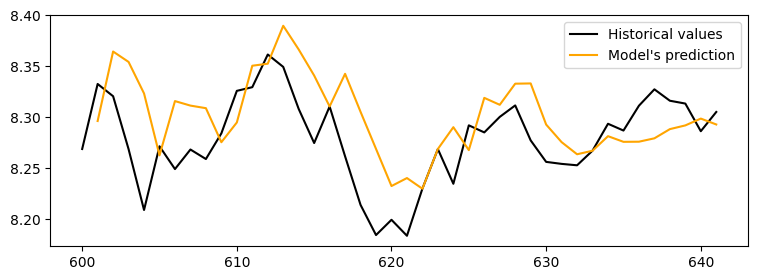

In [18]:
final_forecast = forecast + forecasted_mean
final_prediction = prediction + predicted_cond_vol
final_forecast_prediction = pd.concat([final_prediction, final_forecast], axis=0, join='inner')
plt.plot(y[600:], label='Historical values', color='black')
plt.plot(final_forecast_prediction[600:], label='Model\'s prediction', color='orange')
plt.legend()
plt.show()

In [20]:

print('ARIMA particular errors:')
print('Max error: ', max_error(y_test, forecast))
print('MAE: ',mean_absolute_error(y_test, forecast))
print('MAPE: ',mean_absolute_percentage_error(y_test, forecast))
print('MSE: ',mean_squared_error(y_test, forecast),'\n\n')

print('ARIMA-GARCH errors:')
print('Max error: ', max_error(y_test, final_forecast))
print('MAE: ',mean_absolute_error(y_test, final_forecast))
print('MAPE: ',mean_absolute_percentage_error(y_test, final_forecast))
print('MSE: ',mean_squared_error(y_test, final_forecast))

ARIMA particular errors:
Max error:  0.052257490217863634
MAE:  0.021666763608976503
MAPE:  0.002607556180980052
MSE:  0.0006878903128423916 


ARIMA-GARCH errors:
Max error:  0.04804388967561479
MAE:  0.0191386032836272
MAPE:  0.0023034685685177783
MSE:  0.0005479307118502378


In [21]:
print('Max error change: ', max_error(y_test,final_forecast)*100/max_error(y_test,forecast) - 100, '%')
print('MAE change: ', mean_absolute_error(y_test,final_forecast)*100/mean_absolute_error(y_test,forecast) - 100, '%')
print('MAPE change: ', mean_absolute_percentage_error(y_test,final_forecast)*100/mean_absolute_percentage_error(y_test,forecast) - 100, '%')
print('MSE change: ', mean_squared_error(y_test,final_forecast)*100/mean_squared_error(y_test,forecast) - 100, '%')

Max error change:  -8.063151377309097 %
MAE change:  -11.668380063471474 %
MAPE change:  -11.661785647432623 %
MSE change:  -20.346209036413796 %


In percentage terms adding GARCH component improved model's predictions. It's better, but still model should be developed - I will add more crucial statistical tests and more exogenious variables.<br><br>
Moreover, I will do ex-ante forecast during next weeks.